<a href="https://colab.research.google.com/github/nalgo-intern/team-c-2024-summer-08-26/blob/main/bigmodel_training_goodone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

BATCH_SIZE = 1
CLASS = 2
EPOCH = 24
lr = 0.001

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
mainpath = '/content/drive/MyDrive/'
trainpath = mainpath + 'train/'
annt = mainpath + 'annotation.txt'

In [ ]:
def loadDataSet(dataPath):
    data = []
    file = open(dataPath, "r")
    content_list = file.readlines()
    for i in range(len(content_list)):
        txt = content_list[i]
        imglabel = txt.split()
        img = imglabel[0]
        label = 0 if imglabel[-1].endswith('g') else int(imglabel[-1][-1])
        #print(label)
        data.append([img,label])

    random.shuffle(data)

    X = [] #image
    Y = [] #labels
    for img,l in data:
      X.append(img)
      Y.append(l)
    X = np.array(X)
    Y = np.array(Y).reshape(len(Y),1)

    return X,Y

names,labels = loadDataSet(annt)

In [ ]:
# def loadToImage(array):
#     imagarray=[]
#     imageSize = 64
#     for filename in array:
#         # print(train+filename)
#         image = cv2.imread(trainpath+filename,0)
#         image = cv2.resize(image,(imageSize,imageSize))
#         imagarray.append(image)
#     return imagarray
# images = loadToImage(names)
# images = np.array(images)

In [ ]:
from concurrent.futures import ThreadPoolExecutor
def load_single_image(filename):
    imageSize = 64
    image = cv2.imread(trainpath + filename, 0)
    return cv2.resize(image, (imageSize, imageSize))

def loadToImage(array):
    with ThreadPoolExecutor() as executor:
        imagarray = list(executor.map(load_single_image, array))
    return imagarray

images = loadToImage(names)
images = np.array(images)
#print(images)

In [ ]:
# for i in range(5):
#     plt.imshow(images[i],cmap='gray')
#     plt.show()
#     print(labels[i])

In [ ]:
import torch
from torchvision import datasets
from torch.utils.data.dataset import Subset
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T

transform = T.Compose([T.Normalize(mean=[0.5], std=[0.5])])

images = images.astype(np.float32) / 255.0
images_tensor = torch.from_numpy(images).unsqueeze(-3)
labels_tensor = torch.from_numpy(labels).long()
# print(labels_tensor.shape)
# print(labels_tensor)

# # ラベルが適切な形状であることを確認
# if len(labels_tensor.shape) > 1:
#     labels_tensor = torch.argmax(labels_tensor, dim=1)  # マルチラベル形式の場合
labels_tensor = labels_tensor.squeeze(dim=1)
print(labels_tensor.shape)
print(labels_tensor)

class CustomDataset(Dataset):
  def __init__(self, images, labels, transform):
    self.images = images
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]
    #print(image.shape)
    if self.transform:
      image = self.transform(image)

    return image, label

# カスタムデータセットを作成
datasets = CustomDataset(images_tensor, labels_tensor, transform=transform)

# 訓練データ、検証データ、テストデータに分割
from torch.utils.data import random_split
train_size = int(0.8 * len(datasets))
test_size = len(datasets) - train_size
train_dataset, test_dataset = random_split(datasets, [train_size, test_size])

# DataLoaderの作成
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

torch.Size([902])
tensor([0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 1, 1,

In [ ]:
# import torch.nn as nn

# class Net(nn.Module):
#   def __init__(self, class_num):
#     super(Net, self).__init__()
#     self.feature = nn.Sequential(
#           # ブロック1
#           nn.Conv2d(1, 32, kernel_size=3, padding=(1,1), padding_mode="replicate"),
#           nn.ReLU(),
#           nn.Conv2d(32, 64, kernel_size=3, padding=(1,1), padding_mode="replicate"),
#           nn.ReLU(),
#           nn.MaxPool2d((2,2)),
#           nn.Dropout(0.25),

#           # ブロック2
#           nn.Conv2d(64, 128, kernel_size=3, padding=(1,1), padding_mode="replicate"),
#           nn.ReLU(),
#           nn.Conv2d(128, 128, kernel_size=3, padding=(1,1), padding_mode="replicate"),
#           nn.ReLU(),
#           nn.MaxPool2d((2,2)),
#           nn.Dropout(0.25)
#     )
#     self.classifier = nn.Sequential(
#         nn.Linear(32768, 512),
#         nn.Dropout(0.5),
#         nn.Linear(512, class_num)

#     )

#   def forward(self, x):
#     x = self.feature(x)
#     x = x.view(x.size()[0], -1)
#     #print(x.size())
#     x = self.classifier(x)
#     return x

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, class_num):
        super(Net, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=(1,1), padding_mode="replicate"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=(1,1), padding_mode="replicate"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=(1,1), padding_mode="replicate"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=(1,1), padding_mode="replicate"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, class_num)
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

In [ ]:
import torch.optim as optim

net = Net(class_num = CLASS)
net = net.to(device)
cel = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [ ]:
# train_loss_list = []
# train_acc_list = []
# test_loss_list = []
# test_acc_list = []

# for epoch in range(EPOCH):

#   # モデル学習
#   train_loss_num = 0
#   train_num = 0
#   train_correct_num = 0

#   for (inputs, labels) in train_loader:
#     #print(labels.shape, inputs.shape)
#     inputs, labels = inputs.to(device), labels.to(device)
#     optimizer.zero_grad()
#     outputs = net(inputs)
#     loss = cel(outputs, labels)
#     loss.backward()
#     optimizer.step()
#     loss = cel(outputs, labels)
#     train_loss_num += loss.item()
#     _, predicted = outputs.max(1)
#     train_num += labels.size(0)
#     train_correct_num += (predicted == labels).sum().item()

#   # 学習ごとの検証
#   test_loss_num = 0
#   test_num = 0
#   test_correct_num = 0

#   with torch.no_grad():
#     for (inputs, labels) in test_loader:
#       #print(labels)
#       inputs, labels = inputs.to(device), labels.to(device)
#       optimizer.zero_grad()
#       outputs = net(inputs)
#       loss = cel(outputs, labels)
#       test_loss_num += loss.item()
#       _, predicted = outputs.max(1)
#       test_num += labels.size(0)
#       test_correct_num += (predicted == labels).sum().item()

#   if epoch % 1 == 0:
#     print(f"学習回数：{epoch}, train_loss値:{train_loss_num/train_num}, train_正解率：{train_correct_num/train_num},  test_loss値:{test_loss_num/test_num}, test_正解率：{test_correct_num/test_num}")

#   train_loss_list.append(train_loss_num/train_num)
#   train_acc_list.append(train_correct_num/train_num)
#   test_loss_list.append(test_loss_num/test_num)
#   test_acc_list.append(test_correct_num/test_num)


In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(EPOCH):

    # モデル学習
    train_loss_num = 0
    train_num = 0
    train_correct_num = 0

    net.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = cel(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss_num += loss.item()
        _, predicted = outputs.max(1)
        train_num += labels.size(0)
        train_correct_num += (predicted == labels).sum().item()

    # 学習ごとの検証
    test_loss_num = 0
    test_num = 0
    test_correct_num = 0

    net.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = cel(outputs, labels)
            test_loss_num += loss.item()
            _, predicted = outputs.max(1)
            test_num += labels.size(0)
            test_correct_num += (predicted == labels).sum().item()

    print(f"学習回数：{epoch}, train_loss値: {train_loss_num/train_num}, train_正解率：{train_correct_num/train_num}, test_loss値: {test_loss_num/test_num}, test_正解率: {test_correct_num/test_num}")

    train_loss_list.append(train_loss_num/train_num)
    train_acc_list.append(train_correct_num/train_num)
    test_loss_list.append(test_loss_num/test_num)
    test_acc_list.append(test_correct_num/test_num)

学習回数：0, train_loss値: 4.473968429643357, train_正解率：0.5672676837725381, test_loss値: 0.8034966481818678, test_正解率: 0.39226519337016574
学習回数：1, train_loss値: 0.6793655227022387, train_正解率：0.636615811373093, test_loss値: 0.6848654141906876, test_正解率: 0.6077348066298343
学習回数：2, train_loss値: 0.6750735853454447, train_正解率：0.6158113730929264, test_loss値: 1.1422569448879576, test_正解率: 0.40331491712707185
学習回数：3, train_loss値: 0.7220065218593262, train_正解率：0.6421636615811374, test_loss値: 1.0448020863660628, test_正解率: 0.4088397790055249
学習回数：4, train_loss値: 0.6927351668972772, train_正解率：0.6463245492371706, test_loss値: 0.8487275852230043, test_正解率: 0.430939226519337
学習回数：5, train_loss値: 0.6629299545568904, train_正解率：0.6504854368932039, test_loss値: 0.6943033077851843, test_正解率: 0.580110497237569
学習回数：6, train_loss値: 0.6342288938869738, train_正解率：0.6685159500693482, test_loss値: 0.7628946951822023, test_正解率: 0.48066298342541436
学習回数：7, train_loss値: 0.5985895699289632, train_正解率：0.6893203883495146, test_l

In [ ]:
print(train_loss_list)

[4.473968429643357, 0.6793655227022387, 0.6750735853454447, 0.7220065218593262, 0.6927351668972772, 0.6629299545568904, 0.6342288938869738, 0.5985895699289632, 0.5662698122160542, 0.5148632292988921, 0.4483593071423397, 0.48171492105047825, 0.40413199193866883, 0.3725519774074678, 0.2848705119557919, 0.30053115350303544, 0.26590186968451196, 0.2777317220491471, 0.22927031630007055, 0.26227661303451233, 0.23330477608476338, 0.20168920851796907, 0.1888988687562797, 0.18172511289470408]


In [ ]:
# 重みを保存する
model_path = mainpath + 'modelnew.kpl'
torch.save(net.to("cpu").state_dict(), model_path)

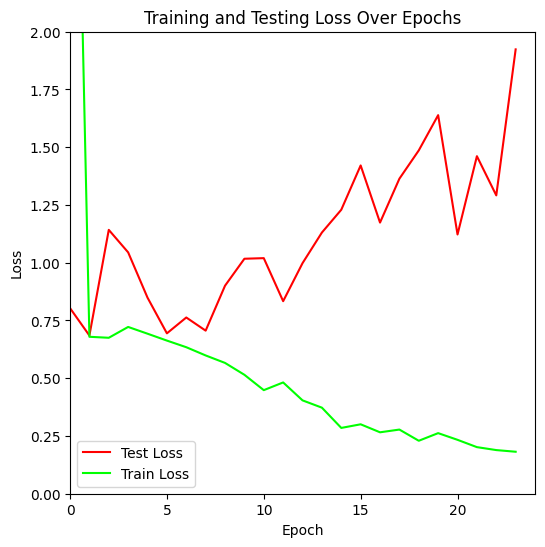

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(range(EPOCH), test_loss_list, label="Test Loss", c="#ff0000")  # You can specify a color for the test loss curve
plt.plot(range(EPOCH), train_loss_list, label="Train Loss", c="#00ff00")
plt.xlim(0, EPOCH)
plt.ylim(0, 2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()  # Add a legend to distinguish the curves
plt.title("Training and Testing Loss Over Epochs")  # Optional: Add a title for clarity
plt.show()  # Show the plot

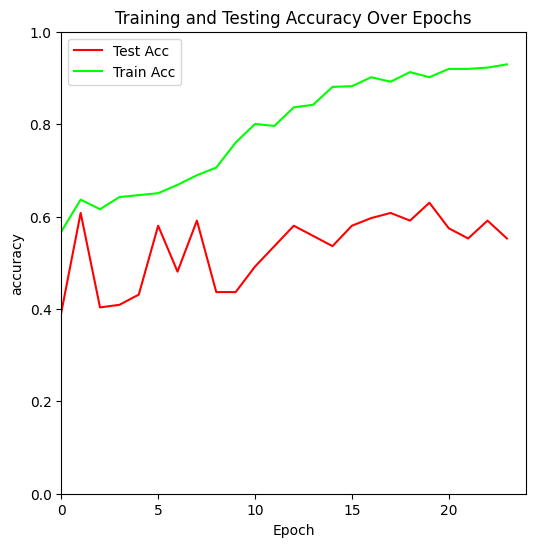

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(range(EPOCH), test_acc_list, label="Test Acc", c="#ff0000")  # You can specify a color for the test loss curve
plt.plot(range(EPOCH), train_acc_list, label="Train Acc", c="#00ff00")
plt.xlim(0, EPOCH)
plt.ylim(0, 1)
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend()  # Add a legend to distinguish the curves
plt.title("Training and Testing Accuracy Over Epochs")  # Optional: Add a title for clarity
plt.show()  # Show the plot

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.optim as optim
from PIL import Image
import numpy as np

class Net(nn.Module):
    def __init__(self, class_num):
        super(Net, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=(1,1), padding_mode="replicate"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=(1,1), padding_mode="replicate"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=(1,1), padding_mode="replicate"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=(1,1), padding_mode="replicate"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, class_num)
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

class Model():
  def __init__(self, path, num_class=2):
    # Netクラスのインスタンス化
    model = Net(num_class)
    model_path = mainpath + 'modelnew.kpl'
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    # 前処理を行う
    input = self.pretreatment(path)
    #画像判別
    self.output = model(input)
    self.prob = nn.functional.softmax(self.output, dim=1) #確率に変換する
    self.result = torch.argmax(self.output).item()


  def pretreatment(self, img_path, new_size=(64, 64)):
    img = np.array(Image.open(img_path))

    weights = np.array([0.2989, 0.5870, 0.1140])
    gray_image = np.dot(img[...,:3], weights)

    pil_image = Image.fromarray((gray_image * 255).astype(np.uint8))
    pil_image_resized = pil_image.resize(new_size, Image.LANCZOS)
    resized_image = np.array(pil_image_resized).astype(np.float32) / 255.0

    transform = T.Compose([T.Normalize(mean=[0.5], std=[0.5])])
    image_tensor = torch.from_numpy(resized_image).unsqueeze(-3).unsqueeze(-4)
    image = transform(image_tensor)

    return image

if __name__ == "__main__":
    #model = Model(path="./page/steak.png")
    model = Model(path=mainpath + "/test/pp.jpeg")
    print(model.result)
    print(model.prob)

<ipython-input-31-b4a0d8c5e6d1>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


0
tensor([[0.9205, 0.0795]], grad_fn=<SoftmaxBackward0>)


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.optim as optim
from PIL import Image
import numpy as np
import os

class Net(nn.Module):
    def __init__(self, class_num):
        super(Net, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, padding_mode="replicate"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, padding_mode="replicate"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, padding_mode="replicate"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, padding_mode="replicate"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),  # Adjust the input size to match the output from `feature`
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, class_num)
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

class Model():
    def __init__(self, path, num_class=2, model_path='modelnew.pth'):
        # Ensure the model path exists
        if not os.path.isfile(model_path):
            raise FileNotFoundError(f"Model file not found: {model_path}")

        # Instantiate and load the model
        self.model = Net(num_class)
        self.model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        self.model.eval()  # Set the model to evaluation mode

        # Preprocess the image
        input_image = self.pretreatment(path)
        input_tensor = input_image.unsqueeze(0)  # Add batch dimension

        # Make predictions
        with torch.no_grad():
            self.output = self.model(input_tensor)
            self.prob = nn.functional.softmax(self.output, dim=1)  # Convert to probabilities
            self.result = torch.argmax(self.output, dim=1).item()  # Get the predicted class index

    def pretreatment(self, img_path, new_size=(64, 64)):
        img = np.array(Image.open(img_path).convert('RGB'))

        weights = np.array([0.2989, 0.5870, 0.1140])
        gray_image = np.dot(img[...,:3], weights)

        pil_image = Image.fromarray((gray_image * 255).astype(np.uint8))
        pil_image_resized = pil_image.resize(new_size, Image.LANCZOS)
        resized_image = np.array(pil_image_resized).astype(np.float32) / 255.0

        transform = T.Compose([T.Normalize(mean=[0.5], std=[0.5])])
        image_tensor = torch.from_numpy(resized_image).unsqueeze(0)  # Add channel dimension
        image = transform(image_tensor)

        return image

if __name__ == "__main__":
    # Define path to the model and image
    model_path = mainpath + 'modelnew.kpl'
    image_path = mainpath + 'test/image2.jpeg'

    # Initialize and use the model
    model = Model(path=image_path, model_path=model_path)
    print(f"Predicted class: {model.result}")
    print(f"Class probabilities: {model.prob}")

<ipython-input-53-7d58b2f64239>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


Predicted class: 0
Class probabilities: tensor([[0.5247, 0.4753]])
